# SA-OT Model (With Iterated Learning) of Jespersen's Cycle - A Replication of Lopopolo & Biro (2011)

## Model Overview
SA-OT (Simulated Annealing for Optimality Theory) extends classical Optimality Theory (OT), which models linguistic competence, by integrating a stochastic search algorithm that models linguistic performance. 
As such it relies on the basic components of standard OT:
- a **candidate set** of linguistic forms,
- a set of **constraints**, ranked into **hierarchies** that represent different grammars.

In addition, it introduces two new elements that allows modeling performance variation:
- a **neighborhood structure (topology)** that organizes the candidate set by structural similarity, and
- a **search algorithm** -- specifically, simulated annealing -- that performs a random walk through this candidate space, guided by a harmony function derived from the constraint hierarchy.

Since the search is stochastic, SA-OT does not always find the globally optimal candidate. Instead, it might settle on local optima, which is how SA-OT models linguistic performance, not just idealized grammatical competence. It predicts not only optimal (grammatical) forms but also suboptimal outputs (e.g., errors arising from fast speech, slips of the tongue, or tolerable irregularities) and thus accounts for linguistic variation and change. 

# Model Setup

## Libraries & Global Variables

In [153]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Candidates & Neighbors

A **candidate** is a pair of underlying form and surface form (uf, sf):
- **uf**: represents the semantics, i.e., the polarity of the utterance -- *positive* or *negative*; 
- **sf**: a *binary syntactic tree*, composed of a main verb (V) and zero or more sentential negation markers (SN). 

---
The **neighbors** of a candidate are candidates whose sf's are the results of transforming the original candidate's sf via the following basic steps: 
1. Add an SN at the beginning (left side);
2. Add an SN at the end (right side);
3. Remove the outermost SN;
4. Reverse the order of the sentence parts (e.g., turn [SN, V] into [V, SN]).

Note: the neighborhood structure (topology) is thus infinite. 

In [154]:
# ----- Utility functions -----
def to_tuple(x):
    """Convert nested list to nested tuple."""
    if isinstance(x, list):
        return tuple(to_tuple(i) for i in x)
    return x

def to_list(x):
    """Convert nested tuple to nested list."""
    if isinstance(x, tuple):
        return [to_list(i) for i in x]
    return x

def is_leaf(x):
    """Check if the input is a leaf node."""
    # leaf = string (either 'V' or 'SN')
    return isinstance(x, str) and (x == 'V' or x == 'SN')

def flatten_singleton(x):
    """Recursively flatten singleton lists or tuples."""
    while isinstance(x, (list, tuple)) and len(x) == 1:
        x = x[0]
    return x
# ------------------------------------------


# ----- Neighborhood generation -----
def generate_neighbors(sf):
    """Generate neighborhood of a candidate as hashable nested tuples.

    Args:
        sf (str or list or tuple): Surface form as 'V' string only, or nested list/tuple.

    Returns:
        list of tuples or strings: Neighbor candidates as hashable nested tuples or strings.
    """
    # Convert input to list if not already
    sf = to_list(sf) if not isinstance(sf, str) else sf
    
    # Input check: either string 'V' or non-empty list
    if isinstance(sf, str):
        assert sf == 'V', "Input string must be 'V'."
        sf_list = sf
    else:
        assert isinstance(sf, list) and len(sf) > 0
        sf_list = sf

    neighbors = []

    # Basic step 1: Add 'SN' at beginning 
    neighbors.append(['SN', flatten_singleton(sf_list)] if not is_leaf(sf_list) else ['SN', sf_list])
    # Basic step 2: Add 'SN' at end
    neighbors.append([flatten_singleton(sf_list), 'SN'] if not is_leaf(sf_list) else [sf_list, 'SN'])

    # Basic step 3: Remove outermost SN
    if not is_leaf(sf_list):
        if is_leaf(sf_list[0]) and sf_list[0] == 'SN':
            n = sf_list[1:]
            neighbors.append(flatten_singleton(n) if len(n) == 1 else n)
        elif is_leaf(sf_list[-1]) and sf_list[-1] == 'SN':
            n = sf_list[:-1]
            neighbors.append(flatten_singleton(n) if len(n) == 1 else n)

    # Basic step 4a: Reverse any subtree
    if not is_leaf(sf_list):
        for i, subtree in enumerate(sf_list):
            if not is_leaf(subtree):
                reversed_sub = subtree[::-1]
                new_sf = sf_list[:i] + [reversed_sub] + sf_list[i+1:]
                neighbors.append(new_sf)

    # Basic step 4b: Reverse top-level daughters if more than 1
    if not is_leaf(sf_list) and len(sf_list) > 1:
        neighbors.append(sf_list[::-1])

    # Flatten and convert to tuples or keep strings
    result = []
    for n in neighbors:
        f = flatten_singleton(n)
        if isinstance(f, list):
            result.append(to_tuple(f))
        else:
            result.append(f)

    return result
# --------------------------------------


# ----- Example usage -----
c = 'V'
c = ['V']
c = ['SN', 'V']
c = [['SN', 'V'], 'SN']
neighbors = generate_neighbors(c)
print(neighbors)

# Expected output for [SN V]:
#     V, [V SN], [SN [SN V]], [[SN V] SN]

[('SN', (('SN', 'V'), 'SN')), ((('SN', 'V'), 'SN'), 'SN'), ('SN', 'V'), (('V', 'SN'), 'SN'), ('SN', ('SN', 'V'))]


## Constraints, Hierarchies & K-Values

Constraints define the harmony function applied to candidates. 

There are four constraints, directly based on de Swart (2010):
- **Faith\[Neg]**: The polarity (uf) of the candidate must match the presence or absence of SN in the sf. Assigns 1 violation mark for a mismatch. 
    - Note: Since the input will only be negative polarity, 1 mark is given if there is no SN in the candidate sf. 
- **\*Neg**: Punishes every occurrence of SN in the sf, assigning as many violation marks as number of SN in the sf.
- **NegFirst**: Assigns 1 violation mark if candidate has no preverbal SN.
- **NegLast** (FocusLast in de Swart): Assigns 1 violation mark if candidate has no postverbal SN.

In [155]:
# ----- Utility functions -----
def flatten(sf):
    """Utility to flatten nested list or tuple trees using recursion.
    Candidate surface forms with the same linear structure (though different parses)
    are assigned the same number of violation marks by all constraints.
    
    Args:
        sf (list, tuple, or str): The surface form, which can be a nested list/tuple or a string.

    Returns:
        tuple: A flat tuple of surface form string elements.
    """
    if isinstance(sf, str):
        return to_tuple([sf])
    elif isinstance(sf, (list, tuple)):
        return to_tuple([item for sublist in sf for item in flatten(sublist)])
    else:
        return to_tuple([])

def prettify_sf(sf, flat=False):
    """Recursively convert nested tuples/lists to string with bracketed nested or linear structure."""
    if flat:
        sf = flatten(sf)
    if isinstance(sf, (tuple, list)):
        return "[" + " ".join(prettify_sf(sub) for sub in sf) + "]"
    return str(sf)
# ---------------------------------


# ----- Constraint functions -----
def faith_neg(sf):
    """Faith[Neg]: Penalize if negation is not expressed in surface form"""
    return 0 if 'SN' in flatten(sf) else 1

def star_neg(sf):
    """*Neg: Penalize for every negation marker"""
    return flatten(sf).count('SN')

def neg_first(sf):
    """NegFirst: Penalize if no negation at beginning"""
    return 0 if flatten(sf)[0] == 'SN' else 1

def neg_last(sf):
    """NegLast: Penalize if no negation at end"""
    return 0 if flatten(sf)[-1] == 'SN' else 1
# ---------------------------------


# ----- Constraint set -----
CONSTRAINTS_LIST = [faith_neg, star_neg, neg_first, neg_last]

def evaluate_constraints(sf, constraints=CONSTRAINTS_LIST):
    """Evaluate a surface form against a set of constraints."""
    results = {}
    for constraint in constraints:
        results[constraint.__name__] = constraint(sf)
    return results 
# ---------------------------------


# ----- Example usage -----
sf = [[['SN', 'V'], 'SN'], 'SN']
sf_flat = flatten(sf)
results = evaluate_constraints(sf_flat, CONSTRAINTS_LIST)
print(f"Original Surface Form:   {sf}")
print(f"           Prettified:   {prettify_sf(sf, flat=False)}")
print(f"  Linear Surface Form:   {sf_flat}")
print(f"           Prettified:   {prettify_sf(sf, flat=True)}")
print(f"Constraint Violations:   {results}")

Original Surface Form:   [[['SN', 'V'], 'SN'], 'SN']
           Prettified:   [[[SN V] SN] SN]
  Linear Surface Form:   ('SN', 'V', 'SN', 'SN')
           Prettified:   [SN V SN SN]
Constraint Violations:   {'faith_neg': 0, 'star_neg': 3, 'neg_first': 0, 'neg_last': 0}


These constraints are ranked in **hierarchies** and assigned **ranking values (K-values)**, such that the higher the position of a constraint in a hierarchy, the higher its ranking value, and thus the more costly its violation when computing the harmony of candidates. 

In [156]:
# ----- Hierarchies and K-values -----
HIERARCHIES_DICT = {
    "H1": [faith_neg, star_neg, neg_first, neg_last],  # preverbal pure
    "H2": [faith_neg, neg_first, star_neg, neg_last],  # preverbal mixed
    "H3": [faith_neg, neg_first, neg_last, star_neg],  # discontinuous (left)
    "H4": [faith_neg, neg_last, neg_first, star_neg],  # discontinuous (right)
    "H5": [faith_neg, neg_last, star_neg, neg_first],  # postverbal mixed
    "H6": [faith_neg, star_neg, neg_last, neg_first]   # postverbal pure
}

K_VALUES_DEFAULT = [4, 3, 2, 1] # NOTE: These are values ASSOCIATED with the ranks 
                                #       (NOT the ranks themselves), such that
                                #       the higher the rank, the higher the K-value.
                                #       The rank is given by the index of the K-value in the list
                                #       (e.g., K_VALUES[0] = 4 means that the highest ranked constraint has K-value 4,
                                #       and K_VALUES[-1] = 1 means that the lowest ranked constraint has K-value 1).


## Harmony

In [157]:
# ----- Harmony function (violation profile) -----
def harmony(sf, constraint_order):
    """Calculate the harmony of a surface form based on a given hierarchy of constraints.
    Args:
        sf (list or tuple): The surface form of the input candidate.
        constraint_order (list): A list of ordered constraints.
    Returns:
        tuple: A tuple representing the harmony of the surface form given the constraint hierarchy.
    """
    # Flatten the surface form
    sf = flatten(sf)
    return tuple(c(sf) for c in constraint_order)
# ---------------------------------


# ----- Harmony comparison -----
def is_more_harmonic(h1, h2):
    """Compare two harmonies to determine if one is more harmonic than the other.
    Args:
        h1 (tuple): The first harmony to compare.
        h2 (tuple): The second harmony to compare.  
    Returns:    
        bool: True if h1 is more harmonic than h2, False otherwise.
    """
    assert isinstance(h1, tuple) and isinstance(h2, tuple), "Both inputs must be tuples representing harmonies."
    assert len(h1) == len(h2), "Both harmonies must have the same length."
    
    # Compare harmonies lexicographically
    return h1 < h2  # lexicographic comparison 


# ----- Example usage -----
c1 = ['SN', 'V']
c2 = ['SN', ['V', 'SN']] 
hierarchy_name = 'H1'
grammar = HIERARCHIES_DICT[hierarchy_name]
h1 = harmony(c1, grammar)
h2 = harmony(c2, grammar)
print(f"Harmony of {c1} in {hierarchy_name}:\n\t{h1}")
print(f"Harmony of {c2} in {hierarchy_name}:\n\t{h2}")
print(f"Is {c1} more harmonic than {c2} in {hierarchy_name}? {is_more_harmonic(h1, h2)}")

# Find the fatal constraint
f = next(i for i in range(len(h1)) if h1[i] != h2[i])
print(f"Fatal constraint: {grammar[f].__name__}")

Harmony of ['SN', 'V'] in H1:
	(0, 1, 0, 1)
Harmony of ['SN', ['V', 'SN']] in H1:
	(0, 2, 0, 0)
Is ['SN', 'V'] more harmonic than ['SN', ['V', 'SN']] in H1? True
Fatal constraint: star_neg


## SA-OT

The SA-OT algorithm models linguistic performance by searching for the best candidate in the candidate topology given a grammar (i.e., a constraint ranking). Thus, performance emerges from the topology and the search algorithm heuristic. The search algorithm used is **simulated annealing (SA)** -- a random walk (or more specifically, hill climbing) over the topology. It starts from one candidate and explores its neighbors using a random walk guided by how well each form satisfies the grammar. At each step:
- Pick a random neighbor;
- Compare the harmony of the initial candidate and the chosen neighbor:
	- If the neighbor is better (or equally good), move to it;
	- If the neighbor is worse, sometimes still move to it -- especially early on, when the search is more flexible.
- Control flexibility with a temperature parameter:
	- At the start, the temperature is high, so the algorithm explores widely -- even worse options.
	- Over time, the temperature cools, and the algorithm becomes more selective (moves only to better neighbors).
	- Stop when no better neighbors are accepted -> you've reached a local optimum.

In [158]:
# ----- Simulated Annealing Algorithm -----
def sa_ot(initial_sf, constraint_order, k_values=K_VALUES_DEFAULT, 
          K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50,
          verbose=False):
    """Run simulated annealing with optimality theory.

    Args:
        initial_sf (str): The initial surface form.
        constraint_order (list): The order of constraints.
        k_values (list, optional): The K-values for the constraints. Defaults to K_VALUES.
        K_max (int, optional): The maximum K-value. Defaults to 5.
        K_step (int, optional): The step size for K. Defaults to 1.
        t_max (int, optional): The maximum temperature. Defaults to 3.
        t_min (int, optional): The minimum temperature. Defaults to 0.
        t_step (int, optional): The step size for temperature. Defaults to 1.
        max_no_moves (int, optional): The maximum number of moves without improvement. Defaults to 50.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        tuple: The final surface form after simulated annealing.
    """
    current = initial_sf

    # Iterate over temperature schedule
    K = K_max
    no_moves = 0
    iters = 0
    
    # Temperature K will decrease until max_no_moves is reached
    while no_moves < max_no_moves:
        # Iterate over t temperatures
        for t in np.arange(t_max, t_min, -t_step):
            iters += 1
            if verbose:
                print(f"Iteration {iters}, K={K}, t={t}, Current: {current}")
            
            # Randomly select a neighbor of the current candidate
            cand = random.choice(generate_neighbors(current))
            
            # Compute harmonies
            h_cur = harmony(current, constraint_order)
            h_cand = harmony(cand, constraint_order)
            
            # Find index of fatal constraint (i.e., the first constraint where h_cur and h_cand differ)
            f = next((i for i in range(len(h_cur)) if h_cur[i] != h_cand[i]), -1)
            
            # Calculate the difference in harmony for the fatal constraint
            d = h_cand[f] - h_cur[f]
            if verbose:
                print(f"Candidate: {cand},\n\tCurrent Harmony: {h_cur}, Candidate Harmony: {h_cand},\n\tFatal Constraint Index: {f}, Difference: {d}")

            # Decide whether to move to the candidate
            e = 1e-9 if t == 0 else 0  # to avoid division by zero in probability calculation
            if d < 0 or h_cur == h_cand:
                current = cand # move to not-less harmonic neighbor
                no_moves = 0 # reset no_moves if a move is made
                if verbose:
                    print("Moved to not-less harmonic neighbor")
            else:
                if k_values[f] < K:
                    if verbose:
                        print(f"Fatal constraint K-value={k_values[f]} is less than current K={K}")
                    current = cand # move to less harmonic neighbor if k-value of fatal constraint is lower than temperature K
                    no_moves = 0 # reset no_moves if a move is made
                    if verbose:
                        print("Moved to less harmonic neighbor due to K-value")
                elif k_values[f] == K and random.random() < math.exp(-d / (t + e)):
                    current = cand # move to less harmonic neighbor with probability exp(-d / (t + e))
                    no_moves = 0 # reset no_moves if a move is made
                    if verbose:
                        print("Moved to less harmonic neighbor with probability")
                else:
                    no_moves += 1  # increase no_moves if no move is made
                    if verbose:
                        print("Did not move")
        
        K -= K_step  # Decrease K
    return current

In [159]:
# Example usage of simulated annealing with Optimality Theory
initial_sf = 'V'
hierarchy = HIERARCHIES_DICT['H1']

sa_ot(initial_sf, hierarchy, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)

('SN', 'V')

# Exp.1: SA-OT On All Landscapes

Apply each hierarchy to the typology and evaluate the candidates. Obtain 6 landscapes on which to perform SA-OT hill climbing to search for optima. Perform the seach many times and compute proportion of outcomes for each hierarchy.

In [160]:
# ----- Running SA-OT for multiple hierarchies -----
def sa_ot_multiple_runs(hierarchies=HIERARCHIES_DICT, initial_sf=['V'], k_values=K_VALUES_DEFAULT, n=1000, verbose=False):
    """Run SA-OT for multiple hierarchies and return results."""
    if verbose:
        print(f"Running SA-OT for {len(hierarchies)} hierarchies with {n} runs each...")
    
    results = {h: [] for h in hierarchies.keys()}
    
    for h_name, h in hierarchies.items():
        if verbose:
            print(f"Running SA-OT for hierarchy: {h_name}...")
        for i in range(n):
            final_sf = sa_ot(initial_sf, h, k_values=k_values, K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)
            results[h_name].append(final_sf)
    
    return results

n=5000  # Number of runs for each hierarchy
results = sa_ot_multiple_runs(HIERARCHIES_DICT, initial_sf='V', k_values=K_VALUES_DEFAULT, n=n, verbose=True)

Running SA-OT for 6 hierarchies with 5000 runs each...
Running SA-OT for hierarchy: H1...
Running SA-OT for hierarchy: H2...
Running SA-OT for hierarchy: H3...
Running SA-OT for hierarchy: H4...
Running SA-OT for hierarchy: H5...
Running SA-OT for hierarchy: H6...


,H1,H2,H3,H4,H5,H6
[SN V],1.0,0.48,0.00,0.00,0.00,0.0
[SN [V SN]],0.0,0.52,0.46,0.52,0.00,0.0
[[SN V] SN],0.0,0.00,0.54,0.48,0.43,0.0
[V SN],0.0,0.00,0.00,0.00,0.57,1.0


<Figure size 1200x600 with 0 Axes>

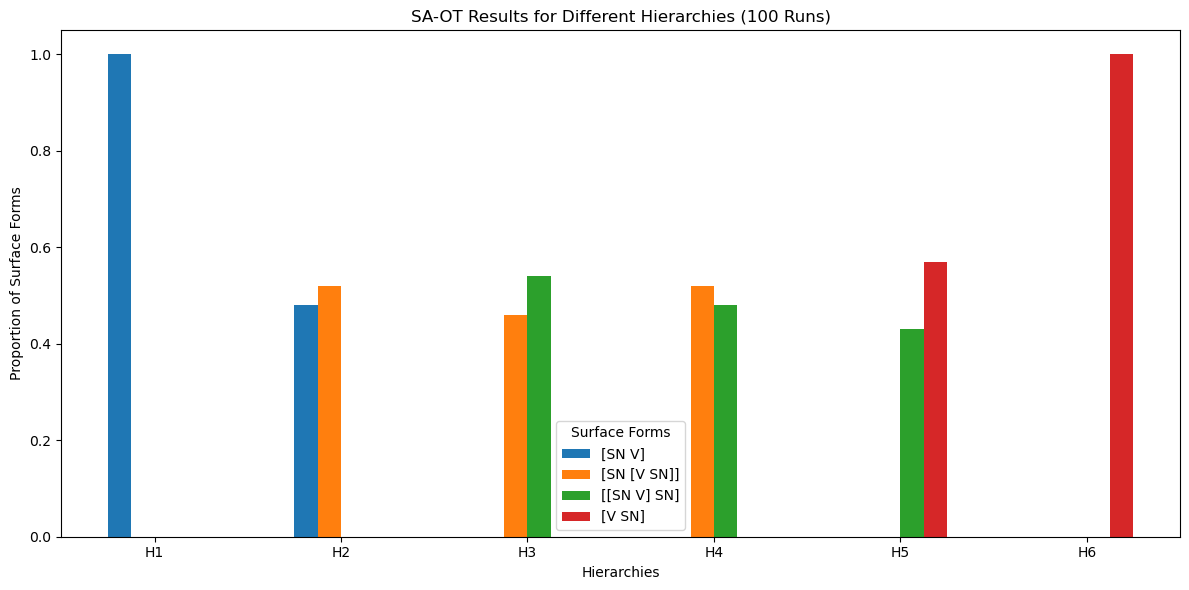

In [133]:
# ----- Analyzing results -----
def count_surface_forms(results, pretty=True, flat=False):
    """
    Count occurrences and calculate proportions of each surface form in the results.

    Args:
        results (dict): Dictionary mapping each hierarchy name to a list of surface forms.
        flatten_outputs (bool): Whether to flatten nested surface forms.

    Returns:
        tuple:
            - results_count (dict): Raw counts of each surface form per hierarchy.
            - results_proportions (dict): Proportions of each surface form per hierarchy.
    """
    results_count = {h: {} for h in results.keys()}
    results_proportions = {}

    for h_name, sf_list in results.items():
        total = len(sf_list)
        
        for sf in sf_list:
            key = prettify_sf(sf, flat=flat) if pretty else sf
            results_count[h_name][key] = results_count[h_name].get(key, 0) + 1

        # Compute proportions
        results_proportions[h_name] = {
            sf: count / total for sf, count in results_count[h_name].items()
        }

    return results_count, results_proportions

results_count, results_proportions = count_surface_forms(results, pretty=True, flat=False)


# ----- Visualizing results -----

# Convert results_proportions to a DataFrame for better visualization
results_df = pd.DataFrame(results_proportions).fillna(0)
display(results_df)

# Plotting the results
plt.figure(figsize=(12, 6))
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title(f'SA-OT Results for Different Hierarchies ({n} Runs)')
plt.xlabel('Hierarchies')
plt.ylabel('Proportion of Surface Forms')
plt.xticks(rotation=0)
plt.legend(title='Surface Forms')
plt.tight_layout()
plt.show()

## Different constraint K-values

Hierarchies 2 and 5 introduce both a global optimum (preverbal negation [SN V] and postverbal negation [V SN], respectively) and a local optimum (the forms of discontinuous negation [SN [V SN]] and [[SN V] SN], repsectively). Simulated annealing applied to these hierarchies produces the global optimum (the "grammatical form") with frequency `p`, and the other local optimum (the "performance errors") with frequency `1 − p`. Thus, `p` is the precision of SA-OT: the probability of finding the grammatical form. The value of this probability depends on the parameters of the algorithm. While `K_max` and `t_step` seem to have minimal impact according to Lopopolo and Biro, the athours find that reducing the ranking value of the lowest-ranked constraint makes the value of `p` vary from a bit over 0.5 to almost 1.0. This is what we test below. Note that from the point of view of traditional OT, decreasing the rank of the lowest ranked constraint does not change the grammar since the order of the constraints remains the same, and the harmony of the candidates are also unaffected. 

In [134]:
k_values_last = [i for i in range(1, -11, -1)]

all_results = {}

for k in k_values_last:
    n = 100  # Number of runs for each hierarchy
    print(f"Running {n} SA-OT simulations for k={k}...")
    k_values = np.array([4, 3, 2, k])
    results = sa_ot_multiple_runs(HIERARCHIES_DICT, initial_sf='V', k_values=k_values, n=n, verbose=False)

    # Count surface forms and compute proportions
    _, results_proportions = count_surface_forms(results, pretty=True, flat=True)

    # Convert proportions to DataFrame
    all_results[k] = pd.DataFrame(results_proportions).fillna(0)

Running 100 SA-OT simulations for k=1...
Running 100 SA-OT simulations for k=0...
Running 100 SA-OT simulations for k=-1...
Running 100 SA-OT simulations for k=-2...
Running 100 SA-OT simulations for k=-3...
Running 100 SA-OT simulations for k=-4...
Running 100 SA-OT simulations for k=-5...
Running 100 SA-OT simulations for k=-6...
Running 100 SA-OT simulations for k=-7...
Running 100 SA-OT simulations for k=-8...
Running 100 SA-OT simulations for k=-9...
Running 100 SA-OT simulations for k=-10...


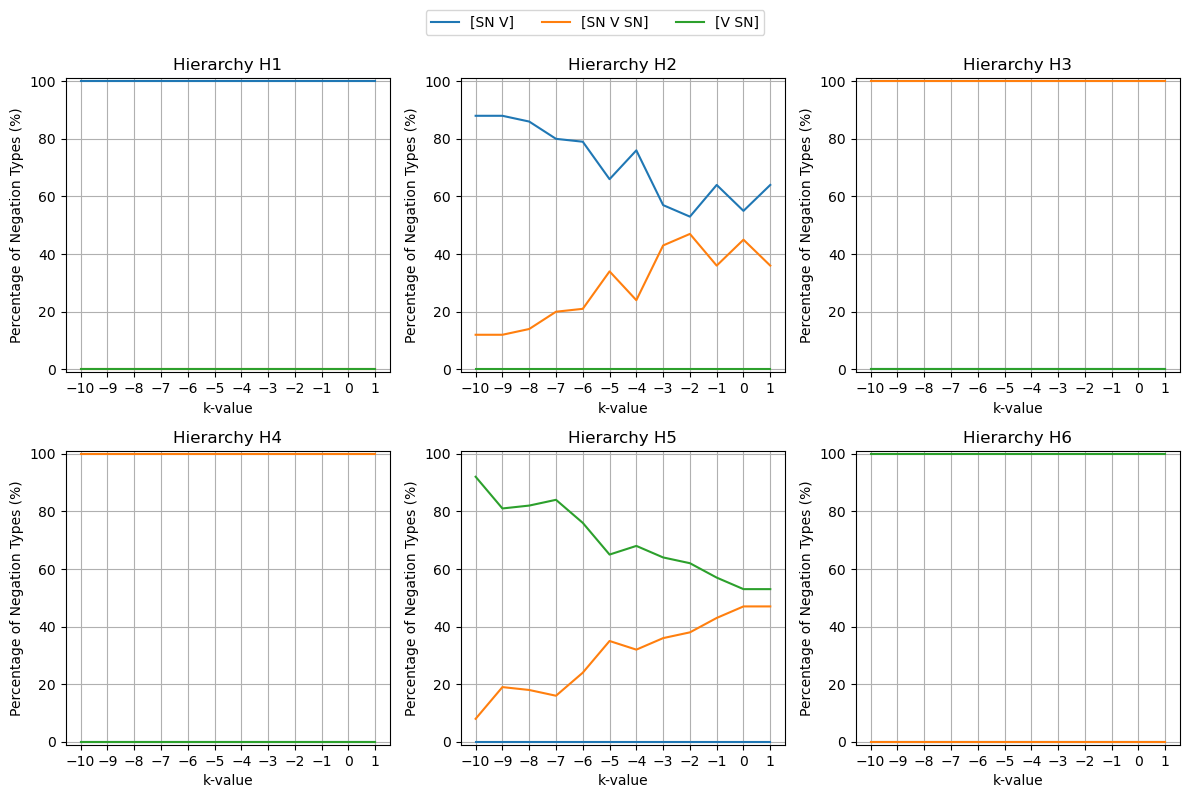

In [135]:
# ----- Plotting the results for each hierarchy across k-values -----

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Go through each hierarchy and plot surface form proportions across k-values
for ax, (h_name, _) in zip(axes.flat, HIERARCHIES_DICT.items()):
    # Build a DataFrame: rows are k-values, columns are prettified surface forms
    df = pd.DataFrame({
        k: all_results[k][h_name] if h_name in all_results[k] else pd.Series()
        for k in k_values_last
    }).T.fillna(0)

    for sf in df.columns:
        ax.plot(k_values_last, df[sf] * 100, label=sf)

    ax.set_title(f'Hierarchy {h_name}')  # \n{">>".join(c.__name__ for c in HIERARCHIES_DICT[h_name])}
    ax.set_xlabel('k-value')
    ax.set_ylabel('Percentage of Negation Types (%)')
    ax.set_xticks(k_values_last)
    ax.set_ylim(-1, 101)
    ax.grid(True)

# Create legend from last processed df (assuming all dfs share same surface forms)
fig.legend(labels=df.columns, loc='upper center', ncol=len(df.columns), bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


# Exp.2: ABM to Simulate Transition Between Stages

The frequencies of the different forms seems to be directly related to the rank values of the constraints. This makes it possible to learn from data with specific frequencies. 

This in turns allows to reproduce the change in dominant grammar on a population level across generations through an **iterated learning simulation** (Kirby & Hurford, 2002) where agents learn from the productions of the immediately preceding generation. 

## GLA

The iterated leaning simulation uses the **Gradual Learning Algoritm** (Boersma, 1997) to model the learning procedure. It works as follows:
When the learner's output differs from the observed target, the ranking values of the constraints are updated by:
- **increasin** the ranking of constraints that favor the target form, and
- **decreasing** the ranking of constraints that favor the learner's erroneous form.

In [136]:
def gla_update(ranks_dict, predicted_sf, observed_sf, plasticity=0.1):
    """
    Performs a single GLA update step.

    Args:
        ranks_dict (dict): Mapping of constraints to their ranking values {constraint_function: float}
        predicted_sf (list): predicted surface form (nested or not)
        observed_sf (list): observed surface form (nested or not)
        plasticity (float): learning rate

    Returns:
        dict: updated ranks (same structure as input)
    """
    updated_ranks = ranks_dict.copy()

    predicted_sf = flatten(predicted_sf)
    observed_sf = flatten(observed_sf)
    
    for constraint_fn in ranks_dict:
        predicted_violations = constraint_fn(predicted_sf)
        observed_violations = constraint_fn(observed_sf)
        diff = observed_violations - predicted_violations

        if diff == 0:
            continue
        if diff > 0:
            updated_ranks[constraint_fn] -= plasticity
        else:
            updated_ranks[constraint_fn] += plasticity

    return updated_ranks


def ranks_dict_to_readable(ranks_dict):
    """Convert dict with function keys to dict with function name keys for display."""
    return {fn.__name__: rank for fn, rank in ranks_dict.items()}


# ----- Example usage of GLA update -----
ranks_dict = {faith_neg: 4.0, star_neg: 3.0, neg_first: 2.0, neg_last: 1.0}

print("Initial ranks:")
print("\t", ranks_dict_to_readable(ranks_dict))

for i in range(5):  # multiple updates
    ranks_dict = gla_update(
        ranks_dict,
        predicted_sf=['SN', 'V'],
        observed_sf=['V', 'SN']
    )
    print(f"Ranks after update {i + 1}:")
    print("\t", ranks_dict_to_readable(ranks_dict))


Initial ranks:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 2.0, 'neg_last': 1.0}
Ranks after update 1:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.9, 'neg_last': 1.1}
Ranks after update 2:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.7999999999999998, 'neg_last': 1.2000000000000002}
Ranks after update 3:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.6999999999999997, 'neg_last': 1.3000000000000003}
Ranks after update 4:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.5999999999999996, 'neg_last': 1.4000000000000004}
Ranks after update 5:
	 {'faith_neg': 4.0, 'star_neg': 3.0, 'neg_first': 1.4999999999999996, 'neg_last': 1.5000000000000004}


## Agent Class

In [142]:
class Agent:
    def __init__(self, id, grammar=None, seed=42):
        """An agent equipped with:
        - an OT grammar (the model of its competence): a set of constraints with associated K-values
        - an SA-OT production procedure (performance)
        - a GLA learning procedure (Boersma, 1997)
        """
        self.id = id

        self.HIERARCHIES_DICT = {
            "H1": [faith_neg, star_neg, neg_first, neg_last],
            "H2": [faith_neg, neg_first, star_neg, neg_last],
            "H3": [faith_neg, neg_first, neg_last, star_neg],
            "H4": [faith_neg, neg_last, neg_first, star_neg],
            "H5": [faith_neg, neg_last, star_neg, neg_first],
            "H6": [faith_neg, star_neg, neg_last, neg_first]
        }
        
        if grammar is None:
            # Randomly initialize K-values for the constraints in the hierarchy, only Faith[Neg] is fixed at 4.9
            self.k_values = np.concatenate(([4.9], np.random.uniform(-0.1, 4.9, size=3)))
            self.grammar = {constraint: k for constraint, k in zip(self.HIERARCHIES_DICT['H1'], self.k_values)}
        else:
            self.k_values = list(np.linspace(-0.1, 4.9, 4))[::-1]  # Default K-values 
            self.grammar = {constraint: k for constraint, k in zip(self.HIERARCHIES_DICT[grammar], self.k_values)}
        
        self.hierarchy_name = self.infer_hierarchy_name()

    def __repr__(self):
        """String representation of the agent."""
        return f"Agent(id={self.id}, hierarchy={self.hierarchy_name}, grammar={self.grammar_dict_to_readable(self.grammar)})"

    def grammar_dict_to_readable(self, grammar_dict):
        """Convert dict with function keys to dict with function name keys for display."""
        return {fn.__name__: rank for fn, rank in grammar_dict.items()}

    def infer_hierarchy_name(self):
        """Infer the hierarchy name based on the grammar (constraint ranking order)."""
        # Sort constraints by descending k-value (highest ranked first)
        ordered_constraints = [constraint for constraint, _ in sorted(self.grammar.items(), key=lambda x: -x[1])]
        for name, hierarchy in self.HIERARCHIES_DICT.items():
            if ordered_constraints == hierarchy:
                return name
        return "Other"  # If no match found, return "Other"

    def learn_from(self, observed_sf):
        """Update the agent's grammar based on observed surface form."""
        # Predict surface form using SA-OT
        predicted_sf = sa_ot(initial_sf='V', 
                             constraint_order=self.HIERARCHIES_DICT[self.hierarchy_name], 
                             k_values=self.k_values,
                             K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)
        if observed_sf == predicted_sf:
            return
        
        # Update grammar using GLA 
        self.grammar = gla_update(self.grammar, predicted_sf, observed_sf)
        self.hierarchy_name = self.infer_hierarchy_name()  # Re-infer hierarchy name after update
    
    def produce_sf(self):
        """Produce a surface form based on the agent's grammar."""
        return sa_ot(initial_sf='V', 
                     constraint_order=self.HIERARCHIES_DICT[self.hierarchy_name], 
                     k_values=self.k_values,
                     K_max=5, K_step=1, t_max=3, t_min=0, t_step=1, max_no_moves=50)

# ----- Example usage of Agent -----
agent = Agent(id=0, grammar='H1')
print(f"Initial agent:\n\t{agent}")
agent.produce_sf()  # Produces a surface form based on the current grammar
observed_sf = ['V', 'SN']  # Example observed surface form
agent.learn_from(observed_sf)  # Update the agent's grammar based on the observed surface form
print(f"Agent after learning from observed surface form {observed_sf}:\n\t{agent}")

Initial agent:
	Agent(id=0, hierarchy=H1, grammar={'faith_neg': np.float64(4.9), 'star_neg': np.float64(3.2333333333333334), 'neg_first': np.float64(1.5666666666666667), 'neg_last': np.float64(-0.1)})
Agent after learning from observed surface form ['V', 'SN']:
	Agent(id=0, hierarchy=H1, grammar={'faith_neg': np.float64(4.9), 'star_neg': np.float64(3.2333333333333334), 'neg_first': np.float64(1.4666666666666666), 'neg_last': np.float64(0.0)})


### Convergence Test

Convergence test simulating  SA-OT with iterated learning to measure how quickly new learner agents born with different grammars adopt the grammar of a teacher (adult) agent. The goal is to understand how stable a target grammar is (in this case, Hierarchy 1) under transmission through GLA-based learning. We analyze:
- How many learning iterations are needed for agents starting from different grammars to converge to H1.
- How consistent that convergence is across multiple independent simulations.
- Whether certain starting grammars (e.g., H2 vs. H6) make convergence easier or harder. 

Run 1/20...
Run 2/20...
Run 3/20...
Run 4/20...
Run 5/20...
Run 6/20...
Run 7/20...
Run 8/20...
Run 9/20...
Run 10/20...
Run 11/20...
Run 12/20...
Run 13/20...
Run 14/20...
Run 15/20...
Run 16/20...
Run 17/20...
Run 18/20...
Run 19/20...
Run 20/20...
[[33. 66. 17. 21.  9.]
 [29. 69. 17. 21.  9.]
 [42. 57. 17. 19.  9.]
 [44. 73. 17. 21.  9.]
 [30. 61. 17. 20.  9.]
 [51. 53. 17. 20.  9.]
 [30. 68. 17. 20.  9.]
 [36. 66. 17. 21.  9.]
 [37. 64. 17. 20.  9.]
 [36. 60. 17. 19.  9.]
 [39. 59. 17. 19.  9.]
 [47. 67. 17. 19.  9.]
 [29. 70. 17. 20.  9.]
 [46. 51. 17. 20.  9.]
 [45. 51. 17. 20.  9.]
 [32. 52. 17. 20.  9.]
 [41. 81. 17. 21.  9.]
 [46. 59. 17. 20.  9.]
 [30. 66. 17. 19.  9.]
 [40. 65. 17. 20.  9.]]


c:\Users\Raya\miniconda3\envs\jc_abm_2.0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\Raya\miniconda3\envs\jc_abm_2.0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


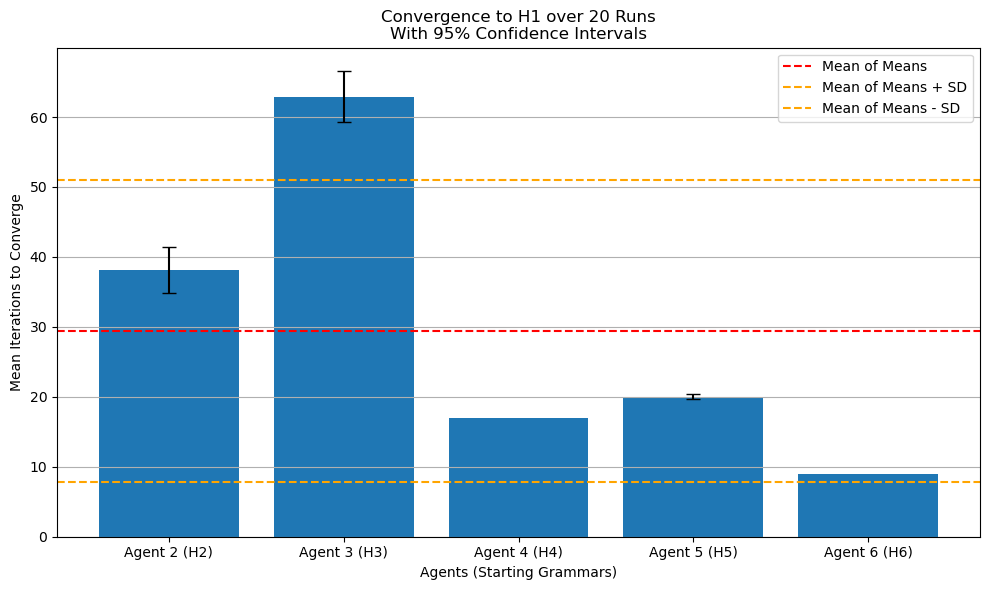

In [138]:
from scipy import stats

# ----- Parameters -----
n_runs = 20  # Number of runs for each agent/grammar
max_iters = 300
hierarchies = list(range(2, 7))  # H2 to H6
n_agents = len(hierarchies)

# Store convergence times: shape = (n_runs, n_agents)
all_learning_iters = np.zeros((n_runs, n_agents))

# ----- Run multiple simulations for each agent/grammar -----
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}...")
    adult_agent = Agent(id=0, grammar='H1')

    for j, h in enumerate(hierarchies):
        new_agent = Agent(id=h, grammar=f'H{h}')
        count = 0

        while new_agent.hierarchy_name != adult_agent.hierarchy_name:
            if count > max_iters:
                all_learning_iters[run, j] = np.nan  # failed to converge
                break
            count += 1
            learner_sf = new_agent.produce_sf()
            observed_sf = adult_agent.produce_sf()
            new_agent.learn_from(observed_sf)

        if count <= max_iters:
            all_learning_iters[run, j] = count

# ----- Compute statistics -----
print(all_learning_iters)

means = np.nanmean(all_learning_iters, axis=0)
stds = np.nanstd(all_learning_iters, axis=0, ddof=1)
n_valid = np.sum(~np.isnan(all_learning_iters), axis=0)  # count of valid runs for each agent

# Compute standard error of the mean (SEM)
stderr = np.divide(stds, np.sqrt(n_valid), out=np.full_like(stds, np.nan), where=n_valid != 0)

# Compute 95% confidence intervals
conf_intervals = stats.t.interval(
    confidence=0.95,
    df=n_valid - 1,
    loc=means,
    scale=stderr
)
lower_ci = means - conf_intervals[0]
upper_ci = conf_intervals[1] - means

# Compute mean of means and standard deviation of means
mean_of_means = np.nanmean(means)
mean_std = np.nanstd(means, ddof=1)

# ----- Plot -----
x = np.arange(len(hierarchies))
plt.figure(figsize=(10, 6))
plt.bar(x, means, yerr=[lower_ci, upper_ci], capsize=5)
plt.xticks(x, [f'Agent {h} (H{h})' for h in hierarchies])
# Plot mean of means and standard deviation of means
plt.axhline(mean_of_means, color='red', linestyle='--', label='Mean of Means')
plt.axhline(mean_of_means + mean_std, color='orange', linestyle='--', label='Mean of Means + SD')
plt.axhline(mean_of_means - mean_std, color='orange', linestyle='--', label='Mean of Means - SD')
plt.legend()
plt.xlabel('Agents (Starting Grammars)')
plt.ylabel('Mean Iterations to Converge')
plt.title(f'Convergence to H1 over {n_runs} Runs\nWith 95% Confidence Intervals')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Model Class

In [ ]:
class Model:
    def __init__(self, pop_size=5, generations=100, gen0_hierarchy='H1',
                 learning_data_size=300, productions_per_agent=100, seed=42):  
        
        self.pop_size = pop_size
        self.generations = generations
        self.gen0_hierarchy = gen0_hierarchy
        self.learning_data_size = learning_data_size
        self.productions_per_agent = productions_per_agent

        self.agents = []
        self.current_gen = 0
        self.HIERARCHIES = [f'H{i}' for i in range(1, 7)]  # List of hierarchy names
        
        self.production_history = {}
        self.initial_hierarchies = {}
        self.hierarchy_evolution = {}  # Track hierarchy evolution over generations

    def __repr__(self):
        """String representation of the model."""
        return (f"Model(pop_size={self.pop_size}, generations={self.generations}, "
                f"initial_hierarchy={self.gen0_hierarchy}, "
                f"learning_data_size={self.learning_data_size}, "
                f"productions_per_agent={self.productions_per_agent})")

    def init_pop(self):
        """Initialize a population of agents with specified initial hierarchy."""        
        for i in range(1, self.pop_size + 1):
            agent = Agent(i, grammar='H1')
            self.agents.append(agent)
    
    def step(self):
        """Perform a single step of the model (i.e., one generation):
        - create new generation of agents with a random grammar, 
        - adjust their grammars based on learning data from the previous generation, 
        - record a production sample once learning is done,
        - replace the old generation with the new one.
        """       
        assert len(self.agents) > 0, "Population must be initialized before stepping."
        
        # Initialize new agents with a randomly chosen hierarchy
        new_agents = []
        id_start = self.current_gen * len(self.agents) + 1
        for i in range(id_start, id_start + self.pop_size):
            agent = Agent(i, grammar=None)  # Randomly initialize grammar
            new_agents.append(agent)
        # Store initial hierarchies for this generation
        self.initial_hierarchies[self.current_gen] = [agent.hierarchy_name for agent in new_agents]
        
        # Each agent learns from (updates their grammar given) observed surface forms produced by the previous generation
        for agent in new_agents: 
            # Each agent is exposed to learning_data_size productions of the previous generation
            for i in range(self.learning_data_size):
                # Randomly select an adult to learn from
                adult = random.choice(self.agents)
                adult_sf = adult.produce_sf()  # Adult produces a surface form
                agent.learn_from(adult_sf)  # Update agent's grammar based on the adult's production
        # After learning, agents in the new generation will produce surface forms based on their updated grammars

        # Store hierarchies for this generation
        self.hierarchy_evolution[self.current_gen] = [agent.hierarchy_name for agent in new_agents]

        # Record production sample from new generation final updated grammars
        production_sample = []
        for agent in new_agents:
            # Each agent produces a sample of surface forms based on its grammar
            for i in range(self.productions_per_agent):
                production = agent.produce_sf()
                production_sample.append(production)  
        assert len(production_sample) == 500, f"Production sample size is {len(production_sample)}, expected 500."
        self.production_history[self.current_gen] = production_sample

        # Replace old generation of agents with the new one
        self.agents = new_agents

    def run(self, generations=None):
        """Run the model for a specified number of generations."""
        # Initialize the preliminary generation of agents (index 0)
        self.init_pop()
        print(f"Model initialized with {self.pop_size} agents.")
        self.current_gen += 1
        
        # Run the model for the specified number of generations
        generations = generations if generations is not None else self.generations
        for i in range(generations):
            if i % 10 == 0:
                print(f"Running generation {self.current_gen}/{generations}...")
            self.step()
            self.current_gen += 1
    
    def plot_history(self, pretty=True, flat=True):
        """Plot the evolution of productions over generations."""
        if pretty:
            # Flatten the sf's in the production history to a list of surface forms
            history = {gen: [prettify_sf(sf, flat=flat) for sf in productions]
                        for gen, productions in self.production_history.items()}
        else:
            history = self.production_history
        
        # Convert production history to DataFrame for plotting
        history_df = pd.DataFrame(history)
        # Count the occurrences of each surface form in the production history
        history_count = history_df.apply(lambda x: x.value_counts()).fillna(0)
        # Convert counts to proportions
        history_proportions = history_count.apply(lambda x: x / x.sum(), axis=0) 
        # Display the proportions of surface forms produced by agents
        display(history_proportions)

        # Plotting the results over generations 
        plt.figure(figsize=(12, 6))
        generations = history_proportions.columns  # Generation numbers (columns)
        for sf in history_proportions.index:  # Surface forms (rows)
            proportions = history_proportions.loc[sf]  # Get proportions for this SF across generations
            plt.plot(generations, proportions, marker='o', label=sf, linewidth=2)

        plt.title("Evolution of Surface Forms Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Proportion")
        plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for proportions
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Model initialized with 5 agents.
Running generation 1/2...
{1: ['H3', 'H5', 'H5', 'H4', 'H4'], 2: ['H3', 'H3', 'H3', 'H2', 'H3']}
{1: ['H2', 'H1', 'H1', 'H1', 'H1'], 2: ['H2', 'H2', 'H1', 'H2', 'H2']}


,1,2
[SN V],0.898,0.642
[SN V SN],0.102,0.358


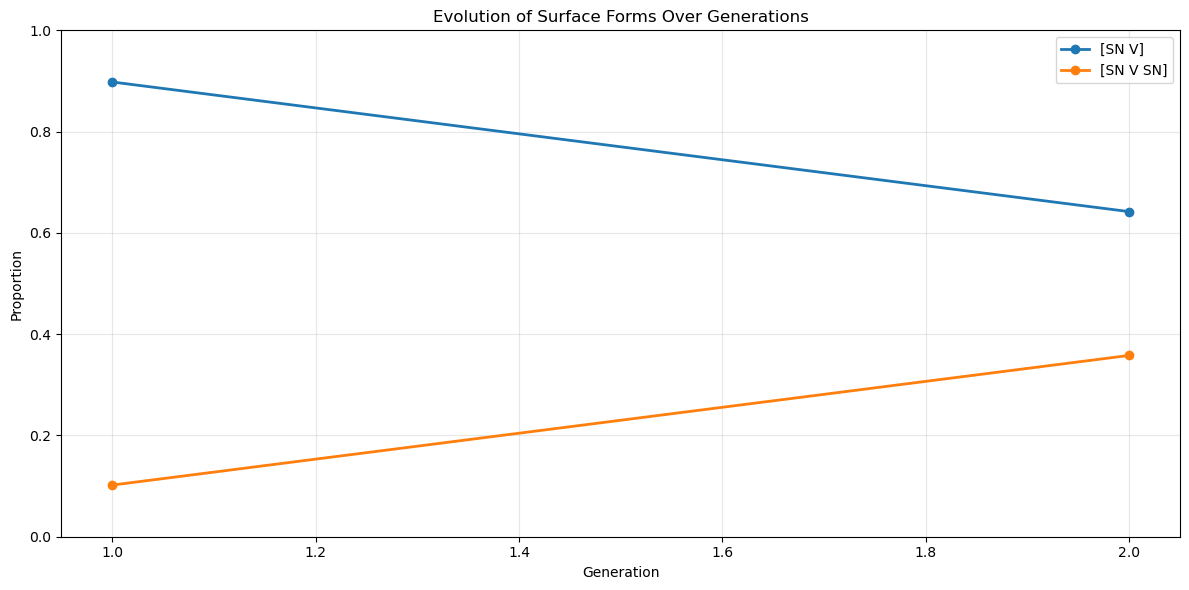

In [ ]:
# ----- Example usage of the Model class -----
model = Model(pop_size=5, generations=2, gen0_hierarchy='H1',
              learning_data_size=50, productions_per_agent=100)
model.run()
print(f"Agents' initial hierarchies: {model.initial_hierarchies}")
print(f"Agents' updated hierarchies: {model.hierarchy_evolution}")
model.plot_history() 

## Multiple simulations

In [ ]:
# ----- Parameters -----
n_simulations = 2
histories = []

# ----- Run multiple simulations -----
for i in range(n_simulations):
    print(f"Running simulation {i + 1}/{n_simulations}...")
    model = Model(pop_size=5, generations=100, gen0_hierarchy='H1',
                  learning_data_size=30, productions_per_agent=100)
    model.run()
    histories.append(model.production_history)
print(f"Simulation {i + 1} completed.")

Running simulation 1/2...
Model initialized with 5 agents.
Running generation 1/10...
Running simulation 2/2...
Model initialized with 5 agents.
Running generation 1/10...


TypeError: '<' not supported between instances of 'tuple' and 'str'

Mean Proportions:
[SN V SN SN]    0.0001
[SN V SN]       0.2385
[SN V]          0.5085
[V SN]          0.2529
dtype: float64


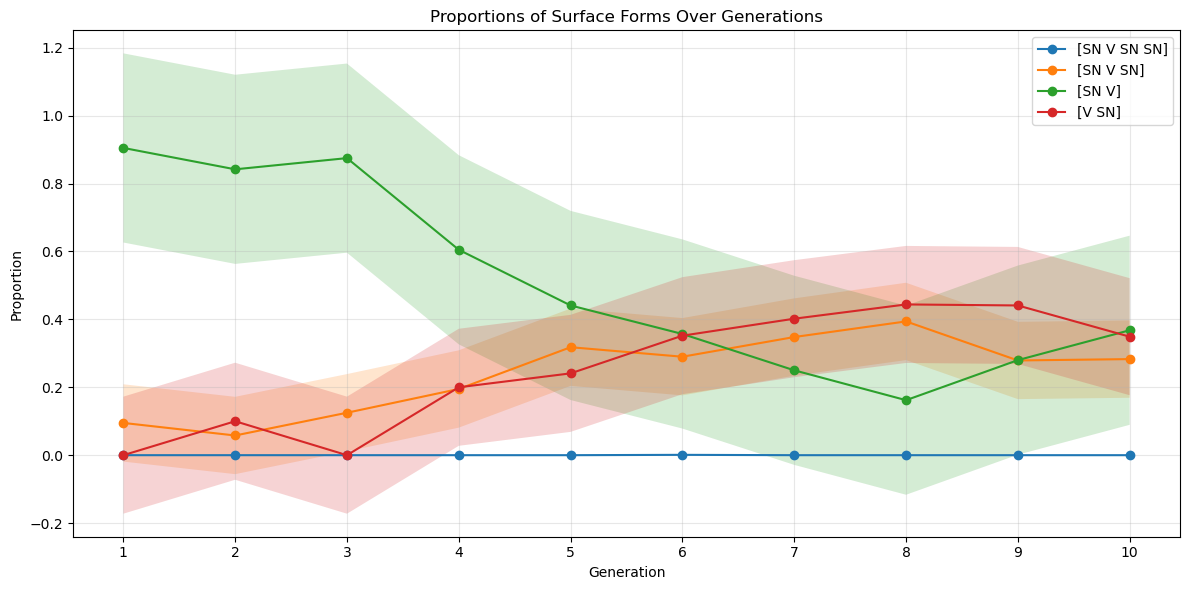

In [152]:
# ----- Combine results -----
all_generations = {}

for history in histories:
    for gen, productions in history.items():
        if gen not in all_generations:
            all_generations[gen] = []
        all_generations[gen].extend(prettify_sf(sf, flat=True) for sf in productions)

# Convert to DataFrame
all_generations_df = pd.DataFrame(all_generations)

# Count occurrences of each surface form
counts = all_generations_df.apply(lambda x: x.value_counts()).fillna(0) 

# Convert counts to proportions
proportions = counts.apply(lambda x: x / x.sum(), axis=0)

# Calculate mean and std deviation across simulations
mean_proportions = proportions.mean(axis=1)
std_proportions = proportions.std(axis=1)

print(f"Mean Proportions:\n{mean_proportions}")

# ----- Plot aggregate results -----
plt.figure(figsize=(12, 6))

# Get generations (x-axis) from proportions columns
generations = proportions.columns
x_axis = range(len(proportions.columns))

for sf in proportions.index:  # Iterate over surface forms
    sf_proportions = proportions.loc[sf].values  # Get array of proportions across generations
    sf_mean = mean_proportions[sf]  # This is still a single value
    sf_std = std_proportions[sf]   # This is still a single value
    
    plt.plot(x_axis, sf_proportions, label=sf, marker='o')
    plt.fill_between(x_axis, 
                    sf_proportions - sf_std, 
                    sf_proportions + sf_std, 
                    alpha=0.2)

plt.title("Proportions of Surface Forms Over Generations")
plt.xlabel("Generation")
plt.ylabel("Proportion")
plt.xticks(x_axis, generations)  # Label x-axis with actual generation numbers
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()